# Research Seminar 1 - Transfer Learning - Yair, Kai
Description:
* This notebook was created for Research Seminar 1 held on 4 April 2025 at YDATA School of Data Science Bootcamp
* In this notebook, we explore the topic of 'Transfer Learning' shared in the paper: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792). We used
  * a similar experiment design (to be shared later in the notebook)
  * the [Sentinel-2 Land Cover Dataset](https://www.kaggle.com/datasets/salmaadell/eurosat-rgb/data)
  * a custom PyTorch Convolutional Neural Network (CNN) model defined by us


In [5]:
!pip install torchsummary

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.v2 as transforms
from torchvision import datasets
from torch.utils.data import Subset, random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import copy


# Model

In [7]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        
        # Input: 3 channels x 64x64
        # Feature map sequence: 3 → 16 → 32 channels
        # Why double channel numbers at each Conv Block?
        # Progressive feature learning
        # Conv Block 1 learns basic patterns
        # Conv Block 2 learns more complex patterns
        self.features = nn.Sequential(
            # Conv Block 1 (64x64 -> 32x32)
            # in_channels, out_channels, kernel_size, stride=1
            nn.Conv2d(3, 16, 3, padding=1),  # Preserve spatial dimensions
            nn.BatchNorm2d(16),               # stabilise training
            nn.ReLU(),                        # relu activation - avoid vanishing gradients
            # kernel_size=2
            # Why perform pooling - decrease spatial dimensions/computations, increase 'receptive field'
            nn.MaxPool2d(2),
            # output from Conv Block 1: 16 channels x 32x32


            # Conv Block 2 (32x32 -> 16x16)
            nn.Conv2d(16, 32, 3, padding=1),
            # From Conv2d: 32 channels x 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Output from Conv Block 2: 16x16x32

            
            # Additional pooling to reduce dimensions further
            # New layer to standardise output size
            nn.AdaptiveAvgPool2d((16, 16))
        )
        

        self.classifier = nn.Sequential(
            nn.Flatten(),                     # Prepare for FC layers
            nn.Linear(32*16*16, 256),         # Reduced feature dimension
            nn.Dropout(0.5),                  # Regularization
            nn.Linear(256, 1),
            nn.Sigmoid()                      # Binary classification output
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [8]:
model = cnn()
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-9           [-1, 32, 16, 16]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 1]             257
          Sigmoid-14                   

# Prepare Dataset
The 2 classes were are interested in are
* AnnualCrop - 27000 RGB jpg image files
* Highway - 27000 RGB jpg image files

In [9]:
import os

n_annualcrop = 0
n_highway = 0
for dirname, _, filenames in os.walk('/kaggle/input/eurosat-rgb/EuroSAT_RGB'):
    for filename in filenames:
        if 'annualcrop' in filename.lower():
            n_annualcrop += 1
        elif 'highway' in filename.lower():
            n_highway += 1

print(f"n_annualcrop: {n_annualcrop}, n_highway: {n_highway}")

n_annualcrop: 3000, n_highway: 2500


In [10]:
# Define transformations that resize the images to 256x256, and normalize them.
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# to simplify our analysis to focus on transfer learning, we will not do additional transformations for the validation set
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
}

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
# Create combined dataset with proper class structure
dataset = datasets.ImageFolder(
    root='/kaggle/input/eurosat-rgb/EuroSAT_RGB',
    transform=data_transforms['all']
)

In [12]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [13]:
# # Filter only AnnualCrop and Forest classes
# Function to create filtered subsets
def create_class_subset(dataset, class_name):
    class_idx = dataset.class_to_idx[class_name]
    indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
    return Subset(dataset, indices)

# Create subsets for each class
annualcrop_subset = create_class_subset(dataset, 'AnnualCrop')  # 3000 samples
highway_subset = create_class_subset(dataset, 'Highway')        # 2500 samples

In [14]:
# annualcrop = datasets.ImageFolder('/kaggle/input/eurosat-rgb/EuroSAT_RGB/AnnualCrop',data_transforms['all'])
# highway = datasets.ImageFolder('/kaggle/input/eurosat-rgb/EuroSAT_RGB/Highway',data_transforms['all'])
seed=38

# Split AnnualCrop subset
train_annualcrop, val_annualcrop = random_split(
    annualcrop_subset,
    [int(0.8*3000), 3000-int(0.8*3000)],
    generator=torch.Generator().manual_seed(seed)
)

# Split Highway subset
train_highway, val_highway = random_split(
    highway_subset,
    [int(0.8*2500), 2500-int(0.8*2500)],
    generator=torch.Generator().manual_seed(seed)
)

# Create final dataset dictionary
image_datasets = {
    'train_annualcrop': train_annualcrop,
    'val_annualcrop': val_annualcrop,
    'train_highway': train_highway,
    'val_highway': val_highway
}

# # Verify splits
print(f"AnnualCrop - Train: {len(image_datasets['train_annualcrop'])}, Val: {len(image_datasets['val_annualcrop'])}")
print(f"highway - Train: {len(image_datasets['train_highway'])}, Val: {len(image_datasets['val_highway'])}")

AnnualCrop - Train: 2400, Val: 600
highway - Train: 2000, Val: 500


In [15]:
# train_size_annual, val_size_annual
# train_size_highway, val_size_highway

In [16]:
dataloaders = {
    'train_annualcrop': torch.utils.data.DataLoader(image_datasets['train_annualcrop'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val_annualcrop': torch.utils.data.DataLoader(image_datasets['val_annualcrop'], batch_size=16,
                                          shuffle=False, num_workers=4),
    'train_highway': torch.utils.data.DataLoader(image_datasets['train_highway'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val_highway': torch.utils.data.DataLoader(image_datasets['val_highway'], batch_size=16,
                                          shuffle=False, num_workers=4)
  }

In [17]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
dataloader_train_annualcrop = dataloaders['train_annualcrop']
dataloader_val_annualcrop = dataloaders['val_annualcrop']
dataloader_train_highway = dataloaders['train_highway']
dataloader_val_highway = dataloaders['val_highway']


### Visualize a few images

In [19]:
# A helper function to show an image from a tensor. We need to restore it to the original dynamic range before normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
# Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloader_train_annualcrop))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title="annualcrop")

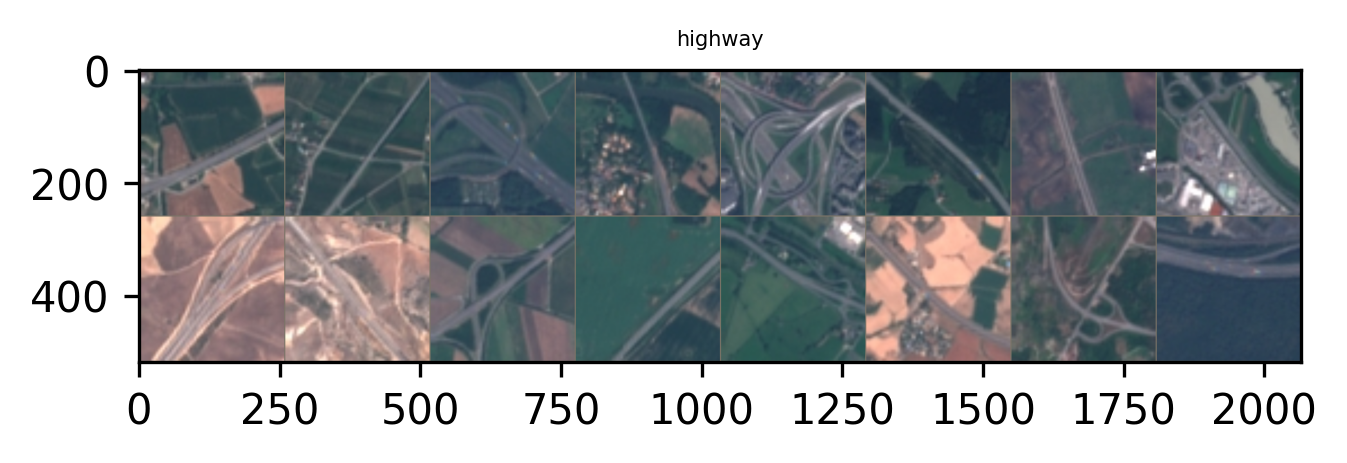

In [21]:
inputs, classes = next(iter(dataloader_train_highway))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title="highway")

# Experiment Design
We need to train the base models - baseA and baseB
* train network A on class 1 - this is baseA
* train network B on class 2 - this is baseB
* Note: To simplify our analysis, we train on just 1 class each for baseA and baseB models. In the paper, baseA and baseB were trained on multiple classes, with no overlap in class labels used to train baseA or baseB

Then from baseA and baseB models, we move on to round 2 of trainings
* **B3B**. **Freeze 'Conv Block 1' from baseB model. Then randomly initialise the remaining layers. Train on dataset B**
* **B3B+**. Same layers as B3B above, but **randomly initialise and train all layers**
* **A3B**. **Freeze 'Conv Block 1' from baseA model**. Then randomly initialise the remaining layers. **Train on dataset B**
* **A3B+**. Same layers as A3B above, but **randomly initialise and train all layers**

# Train BaseA (AnnualCrop), BaseB (Highway) models

In [22]:
baseA_annualcrop = cnn()
baseB_highway = cnn()

In [23]:
# If a GPU is available, make the model use it
baseA_annualcrop = baseA_annualcrop.to(device)
baseB_highway = baseB_highway.to(device)

def setup_expt(model):
    # criterion = nn.CrossEntropyLoss()
    # binary cross entropy to work on a binary classification task
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return criterion, optimizer, exp_lr_scheduler


num_epochs = 30
criterion_baseA, optimizer_baseA, exp_lr_scheduler_baseA = setup_expt(baseA_annualcrop)
criterion_baseB, optimizer_baseB, exp_lr_scheduler_baseB = setup_expt(baseB_highway)

In [24]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device):
    best_acc = 0.0
    # for early stopping
    best_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement
    patience_counter = 0
    improvement_threshold = 0.1 # 10% val loss improvement required
    best_model_wts = copy.deepcopy(model.state_dict())  # Store best weights

    
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            # update model mode to 'train' to enable gradient tracking
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Convert labels to float and set to 1.0 (all samples are positive class)
                labels = torch.ones_like(labels, dtype=torch.float32)
                
                optimizer.zero_grad()

                
                # calculate gradients during training phase
                with torch.set_grad_enabled(phase == 'train'):
                    # outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    outputs = model(inputs).squeeze(1)  # Remove channel dimension
                    preds = (outputs >= 0.5).long()     # Threshold at 0.5 for binary prediction
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        # calculate gradients
                        loss.backward()
                        # update model params
                        # after each batch -> more frequent small updates, hopefully converge faster
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            
            # update learning rate after 'step_size' number of epochs
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            
            if phase == 'val':
                # First epoch validation loss, always accept
                # otherwise 'improvement = nan' across epochs
                if best_loss == float('inf'):
                    best_loss = epoch_loss
                    improvement = 1.0  # 100% improvement from infinity
                # subsequent epochs
                else:
                    improvement = (best_loss - epoch_loss) / best_loss

                
                # Check if improvement meets 10% threshold
                if improvement > improvement_threshold:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    print(f'Improvement: {improvement*100:.1f}%')

                # if improvement is <10% threshold, track patience
                else:
                    patience_counter += 1
                    print(f'Little to no improvement ({(improvement * 100 if not np.isnan(improvement) else 0):.1f}% < {improvement_threshold*100}%)')
                    print(f'EarlyStopping counter: {patience_counter}/{patience}')
                    
                    if patience_counter >= patience:
                        print(f'Early stopping triggered at epoch {epoch}!')
                        model.load_state_dict(best_model_wts)
                        return model

                
                # # Early stopping logic
                # if epoch_loss < best_loss:
                #     best_loss = epoch_loss
                #     best_model_wts = copy.deepcopy(model.state_dict())
                #     patience_counter = 0  # Reset counter
                # else:
                #     patience_counter += 1
                #     print(f'EarlyStopping counter: {patience_counter}/{patience}')
                #     if patience_counter >= patience:
                #         print(f'Early stopping triggered at epoch {epoch}!')
                #         model.load_state_dict(best_model_wts)  # Restore best weights
                #         return model

                # Still track best accuracy, if needed
                if epoch_acc > best_acc:
                    best_acc = epoch_acc

    
    model.load_state_dict(best_model_wts)  # Ensure best weights are loaded
    return model


In [ ]:
# 2025.04.03 commented out here
# because we trained the base models in our 'Part1' notebook
# available from https://www.kaggle.com/code/kaiquanmah/seminar-1-transfer-learning-part1base-yair-kai?scriptVersionId=231344349


# # Train baseA (AnnualCrop)
# print("Training baseA (AnnualCrop classifier)")
# dataloaders = {'train': dataloader_train_annualcrop,
#                'val': dataloader_val_annualcrop}


# baseA_annualcrop = train_model(
#     baseA_annualcrop,
#     dataloaders,
#     criterion_baseA,
#     optimizer_baseA,
#     exp_lr_scheduler_baseA,
#     num_epochs,
#     device
# )

In [30]:
# save the model in our part1 notebook
# available from https://www.kaggle.com/code/kaiquanmah/seminar-1-transfer-learning-part1base-yair-kai?scriptVersionId=231344349
# # Save complete model (architecture + weights)
# torch.save(baseA_annualcrop, 'baseA_annualcrop_full.pth')
# # Save only state_dict (weights)
# torch.save(baseA_annualcrop.state_dict(), 'baseA_annualcrop_weights.pth')


# load the saved models in our part2 notebook
# Load complete model (architecture + weights)
baseA_annualcrop = torch.load('/kaggle/input/seminar-1-transfer-learning-part1base-yair-kai/baseA_annualcrop_full.pth', weights_only=False)
# sanity check model layers
baseA_annualcrop

cnn(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(16, 16))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [ ]:
# 2025.04.03 commented out here
# because we trained the base models in our 'Part1' notebook
# available from https://www.kaggle.com/code/kaiquanmah/seminar-1-transfer-learning-part1base-yair-kai?scriptVersionId=231344349



# # Train baseB (Highway)
# print("\nTraining baseB (Highway classifier)")
# dataloaders = {'train': dataloader_train_highway,
#                'val': dataloader_val_highway}

# baseB_highway = train_model(
#     baseB_highway,
#     dataloaders,
#     criterion_baseB,
#     optimizer_baseB,
#     exp_lr_scheduler_baseB,
#     num_epochs,
#     device
# )

In [31]:
# save the model in our part1 notebook
# available from https://www.kaggle.com/code/kaiquanmah/seminar-1-transfer-learning-part1base-yair-kai?scriptVersionId=231344349
# # Save complete model (architecture + weights)
# torch.save(baseB_highway, 'baseB_highway_full.pth')
# # Save only state_dict (weights)
# torch.save(baseB_highway.state_dict(), 'baseB_highway_weights.pth')


# load the saved models in our part2 notebook
# Load complete model (architecture + weights)
baseB_highway = torch.load('/kaggle/input/seminar-1-transfer-learning-part1base-yair-kai/baseB_highway_full.pth', weights_only=False)
# sanity check model layers
baseB_highway

cnn(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(16, 16))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

# Transfer Learning
Recall from our experiment design
* **B3B**. **Freeze 'Conv Block 1' from baseB model. Then randomly initialise the remaining layers. Train on dataset B**
* **B3B+**. Same layers as B3B above, but **randomly initialise and train all layers**
* **A3B**. **Freeze 'Conv Block 1' from baseA model**. Then randomly initialise the remaining layers. **Train on dataset B**
* **A3B+**. Same layers as A3B above, but **randomly initialise and train all layers**

Note that for reinitialisation
* We reinitialised the layers containing parameters - Conv2d, Linear, BatchNorm2d
* For layers such as MaxPool2d, ReLU, Dropout, Sigmoid, and Flatten - there are no learnable parameters, so there is nothing to re-initialise at these few layers

In [44]:
# A simple function to reinitialize weights for a given layer.
def weights_init(layer_m):
    """
    Reinitialize the weights of layer 'm' based on its type.
    
    - For nn.Conv2d and nn.Linear:
      * Uses Kaiming Normal initialization for the weights,
        which is suitable for layers followed by ReLU activation.
      * Sets biases to 0.
      * mode='fan_out' preserves the magnitude of weight variances in the backward pass
      * https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
      * Implemented by  Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)
      
      * Why not reinitialise using a constant like 0.5 or 1?
      * If you initialize all weights to a constant value (like 1 or 0.5), 
      * every neuron in the layer would start with the same value, and learn the same features
      * during training. This leads to a lack of diversity in learned features
      * and can severely hinder training by causing poor convergence.

      * Kaiming Normal initialization draws weights from a distribution that is scaled
      * for the layer, allowing each neuron to start with different values, and 
      * encourages learning of diverse features.

      * Bias=0 as a Neutral Starting Point
      * so activations are determined solely by the weighted sum of the inputs at the beginning of training
      * letting the learning process discover and adjust the bias over time


      
    - For nn.BatchNorm2d:
      * Sets the weights to 1 and biases to 0.
      
      * Batch normalisation's weight/gamma parameter scales the normalized activations. 
      * Initializing weight=1 means the normalization layer will initially preserve 
      * the scale of the activations
      * during training, let the network learn the optimal scale for activations
      
      * why batch normalisation's bias is 0
      * its bias shifts the normalized activations
      * Initializing it to 0 ensures there is no initial shift/preconceived bias
      * During training, let the network learn the proper offset
      
      
    """
    if isinstance(layer_m, (nn.Conv2d, nn.Linear)):
        # Reinitialize weights using Kaiming Normal initialization.
        nn.init.kaiming_normal_(layer_m.weight, mode='fan_out', nonlinearity='relu')
        
        # If the layer has a bias term, initialize it to 0
        if layer_m.bias is not None:
            nn.init.constant_(layer_m.bias, 0)
            
            
    elif isinstance(layer_m, nn.BatchNorm2d):
        # For BatchNorm layers, set the weight to 1 and bias to 0.
        nn.init.constant_(layer_m.weight, 1)
        nn.init.constant_(layer_m.bias, 0)



# -----------------------------------
# Create new models from the base models
# (we use deepcopy so that we modify weights in-place without altering the original models)
# -----------------------------------

# For the BaseB model (Highway classifier)

# B3B: Freeze Conv Block 1 (features[0:4]) and reinitialize the remaining layers.
B3B = copy.deepcopy(baseB_highway)
# Freeze the 1st convolutional block (layers 0-3 in features)
for param in B3B.features[:4].parameters():
    param.requires_grad = False
# Reinitialize all remaining layers
for layer in B3B.features[4:]:
    layer.apply(weights_init)
# Reinitialize the classifier layers.
B3B.classifier.apply(weights_init)


# B3B+: Reinitialize all layers (no freezing)
B3B_plus = copy.deepcopy(baseB_highway)
B3B_plus.apply(weights_init)




# For the BaseA model (AnnualCrop classifier)
# A3B: Freeze Conv Block 1 (features[0:4]) and reinitialize the remaining layers.
A3B = copy.deepcopy(baseA_annualcrop)
for param in A3B.features[:4].parameters():
    param.requires_grad = False
for layer in A3B.features[4:]:
    layer.apply(weights_init)
A3B.classifier.apply(weights_init)


# A3B+: Reinitialize all layers (no freezing)
A3B_plus = copy.deepcopy(baseA_annualcrop)
A3B_plus.apply(weights_init)

# Verify model architecture
print("B3B model:")
print(B3B)
print("\nB3B+ model:")
print(B3B_plus)
print("\nA3B model:")
print(A3B)
print("\nA3B+ model:")
print(A3B_plus)


B3B model:
cnn(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(16, 16))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

B3B+ model:
cnn(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [42]:
# ========================
# Training Function with History Tracking
# ========================

def train_model_with_history(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device):
    # 2024.04.03: added to track history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    
    best_acc = 0.0
    # for early stopping
    best_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement
    patience_counter = 0
    improvement_threshold = 0.1 # 10% val loss improvement required
    best_model_wts = copy.deepcopy(model.state_dict())  # Store best weights

    
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            # update model mode to 'train' to enable gradient tracking
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Convert labels to float and set to 1.0 (all samples are positive class)
                labels = torch.ones_like(labels, dtype=torch.float32)
                
                optimizer.zero_grad()

                
                # calculate gradients during training phase
                with torch.set_grad_enabled(phase == 'train'):
                    # outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    outputs = model(inputs).squeeze(1)  # Remove channel dimension
                    preds = (outputs >= 0.5).long()     # Threshold at 0.5 for binary prediction
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        # calculate gradients
                        loss.backward()
                        # update model params
                        # after each batch -> more frequent small updates, hopefully converge faster
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            
            # update learning rate after 'step_size' number of epochs
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            
            # 2024.04.03: added to track history
            # Store metrics in history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                
            
            if phase == 'val':
                # First epoch validation loss, always accept
                # otherwise 'improvement = nan' across epochs
                if best_loss == float('inf'):
                    best_loss = epoch_loss
                    improvement = 1.0  # 100% improvement from infinity
                # subsequent epochs
                else:
                    # to avoid division by 0 error, add a small float to the denominator
                    improvement = (best_loss - epoch_loss) / (best_loss + 1e-6)

                
                # Check if improvement meets 10% threshold
                if improvement > improvement_threshold:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    print(f'Improvement: {improvement*100:.1f}%')

                # if improvement is <10% threshold, track patience
                else:
                    patience_counter += 1
                    print(f'Little to no improvement ({(improvement * 100 if not np.isnan(improvement) else 0):.1f}% < {improvement_threshold*100}%)')
                    print(f'EarlyStopping counter: {patience_counter}/{patience}')
                    
                    if patience_counter >= patience:
                        print(f'Early stopping triggered at epoch {epoch}!')
                        model.load_state_dict(best_model_wts)
                        return model, history


                # Still track best accuracy, if needed
                if epoch_acc > best_acc:
                    best_acc = epoch_acc

    
    model.load_state_dict(best_model_wts)  # Ensure best weights are loaded
    return model, history



In [45]:
# ========================
# Training
# ========================

# Dictionary to store all experiment histories
all_histories = {}

# Execute all experiments and store histories
experiments = {
    'A3B': None,
    'A3B+': None,
    'B3B': None,
    'B3B+': None,
}


dataloaders = {'train': dataloader_train_highway,
               'val': dataloader_val_highway}
num_epochs = 30



# A3B
print("training A3B model")
criterion_A3B, optimizer_A3B, exp_lr_scheduler_A3B = setup_expt(A3B)
trained_model, history = train_model_with_history(
    A3B, dataloaders, criterion_A3B,
    optimizer_A3B, exp_lr_scheduler_A3B,
    num_epochs, device
)
torch.save(trained_model, 'A3B_highway_full.pth')
all_histories['A3B'] = history
experiments['A3B'] = trained_model


# A3B+
print("\ntraining A3B+ model")
criterion_A3B_plus, optimizer_A3B_plus, exp_lr_scheduler_A3B_plus = setup_expt(A3B_plus)
trained_model, history = train_model_with_history(
    A3B_plus, dataloaders, criterion_A3B_plus,
    optimizer_A3B_plus, exp_lr_scheduler_A3B_plus,
    num_epochs, device
)
torch.save(trained_model, 'A3B_plus_highway_full.pth')
all_histories['A3B+'] = history
experiments['A3B+'] = trained_model


# B3B
print("\ntraining B3B model")
criterion_B3B, optimizer_B3B, exp_lr_scheduler_B3B = setup_expt(B3B)
trained_model, history = train_model_with_history(
    B3B, dataloaders, criterion_B3B,
    optimizer_B3B, exp_lr_scheduler_B3B,
    num_epochs, device
)
torch.save(trained_model, 'B3B_highway_full.pth')
all_histories['B3B'] = history
experiments['B3B'] = trained_model


# B3B+
print("\ntraining B3B+ model")
criterion_B3B_plus, optimizer_B3B_plus, exp_lr_scheduler_B3B_plus = setup_expt(B3B_plus)
trained_model, history = train_model_with_history(
    B3B_plus, dataloaders, criterion_B3B_plus,
    optimizer_B3B_plus, exp_lr_scheduler_B3B_plus,
    num_epochs, device
)
torch.save(trained_model, 'B3B_plus_highway_full.pth')
all_histories['B3B+'] = history
experiments['B3B+'] = trained_model

training A3B model
Epoch 0/29
----------
train Loss: 41.5726 Acc: 0.4560
val Loss: 36.0171 Acc: 0.4160
Improvement: 100.0%
Epoch 1/29
----------
train Loss: 40.5666 Acc: 0.4705
val Loss: 36.2456 Acc: 0.4040
Little to no improvement (-0.6% < 10.0%)
EarlyStopping counter: 1/5
Epoch 2/29
----------
train Loss: 43.2730 Acc: 0.4525
val Loss: 34.6084 Acc: 0.4200
Little to no improvement (3.9% < 10.0%)
EarlyStopping counter: 2/5
Epoch 3/29
----------
train Loss: 40.1738 Acc: 0.4720
val Loss: 35.3787 Acc: 0.4060
Little to no improvement (1.8% < 10.0%)
EarlyStopping counter: 3/5
Epoch 4/29
----------
train Loss: 38.4471 Acc: 0.4870
val Loss: 35.9128 Acc: 0.4080
Little to no improvement (0.3% < 10.0%)
EarlyStopping counter: 4/5
Epoch 5/29
----------
train Loss: 41.4229 Acc: 0.4555
val Loss: 34.6916 Acc: 0.4160
Little to no improvement (3.7% < 10.0%)
EarlyStopping counter: 5/5
Early stopping triggered at epoch 5!
training A3B+ model
Epoch 0/29
----------
train Loss: 39.7947 Acc: 0.4685
val Loss: 

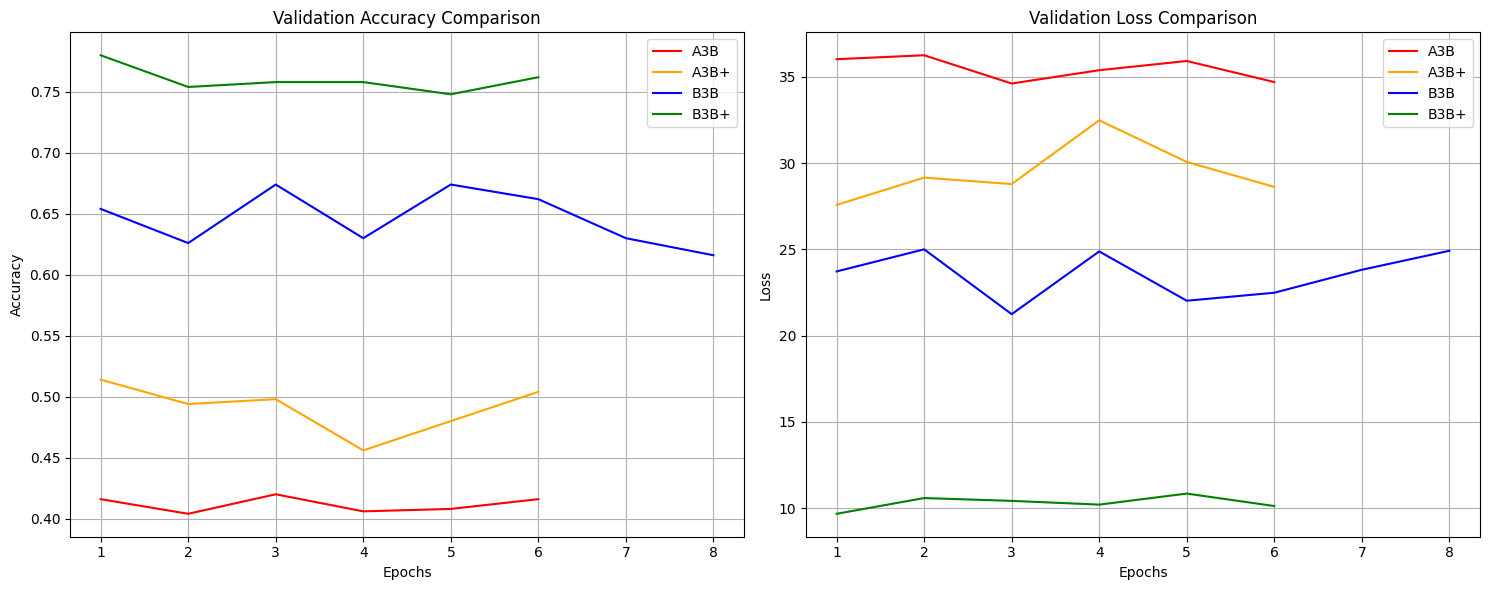

In [51]:
# ========================
# Visualization
# ========================

plt.figure(figsize=(15, 6))
colors = {'B3B': 'blue', 
          'B3B+': 'green', 
          'A3B': 'red', 
          'A3B+': 'orange'}
epochs = range(1, num_epochs+1)

# Plot 1: Validation Accuracy
plt.subplot(1, 2, 1)
for exp_name, history in all_histories.items():
    plt.plot(epochs[:len(history['val_acc'])], 
             history['val_acc'], 
             label=exp_name, 
             color=colors[exp_name])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Plot 2: Validation Loss
plt.subplot(1, 2, 2)
for exp_name, history in all_histories.items():
    plt.plot(epochs[:len(history['val_loss'])], 
             history['val_loss'], 
             label=exp_name, 
             color=colors[exp_name])
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

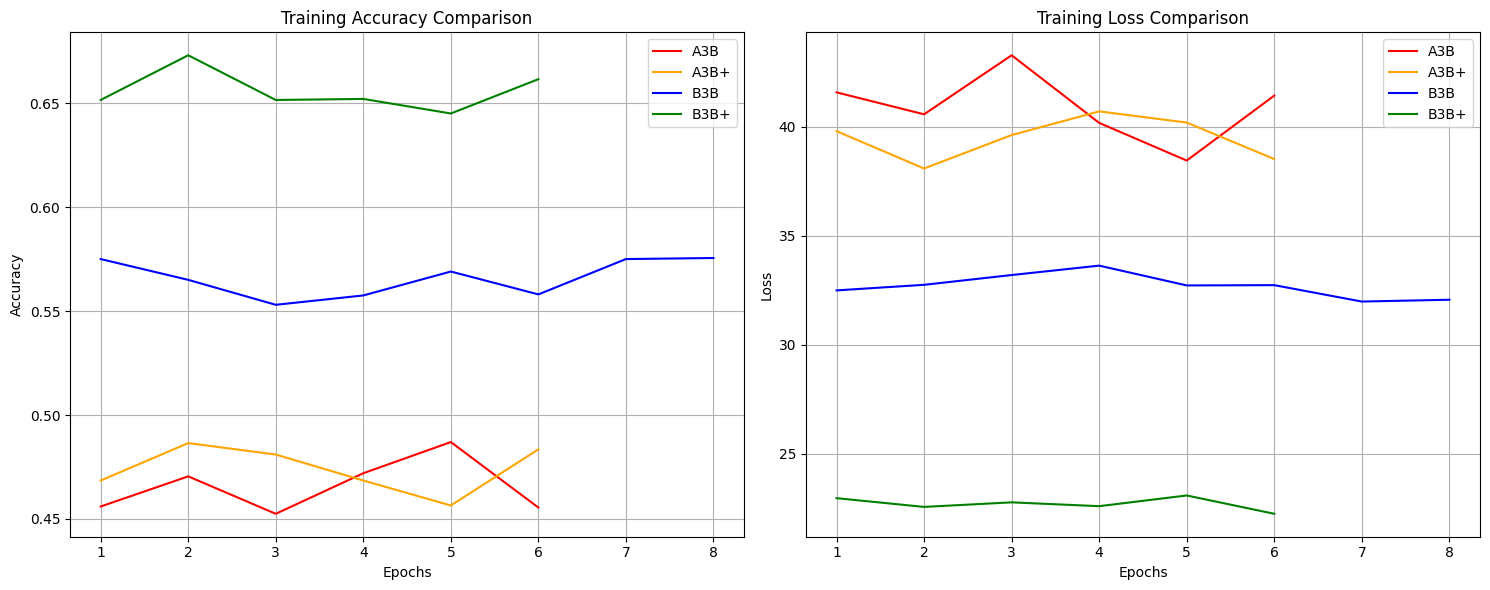

In [53]:
plt.figure(figsize=(15, 6))
# Plot 1: Training Accuracy
plt.subplot(1, 2, 1)
for exp_name, history in all_histories.items():
    plt.plot(epochs[:len(history['train_acc'])], 
             history['train_acc'], 
             label=exp_name, 
             color=colors[exp_name])
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Plot 2: Training Loss
plt.subplot(1, 2, 2)
for exp_name, history in all_histories.items():
    plt.plot(epochs[:len(history['train_loss'])], 
             history['train_loss'], 
             label=exp_name, 
             color=colors[exp_name])
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()